In [1]:
import drag_functions_turb as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from time_TvsR import *
from matplotlib.ticker import MultipleLocator
import scipy.optimize as opt
from matplotlib.colors import LogNorm
from cycler import cycler
from PebAcc_Turb import *
%matplotlib inline
colors = ['#4D4D4D','#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0','#B2912F','#B276B2','#DECF3F','#F15854']
          # (black), (blue), (orange), (green), (pink), (brown), (purple), (yellow), (red)
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

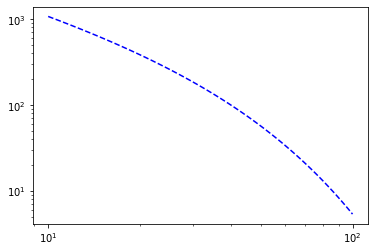

In [2]:
#Disk surface density parameters
m_star_arr = np.linspace(0.1, 10, 100) # Solar masses
t_disk_arr = np.linspace(0.1, 10, 100) # Myrs
alpha_arr = np.array([1e-6, 1e-5, 1e-4, 1e-3])
m_inj_arr = np.logspace(-6, -2, 100) # Earth masses
a_arr = np.linspace(10, 100, 100) # AU
l_star_arr = np.linspace(1e-1, 1e1, 100) # Solar luminosity

def disk_sigma(r=1., sigma0=500., rcrit=100.):
    r_c = rcrit
    gamma = 1.
    sigma = sigma0*((r/r_c)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))
    return sigma

sig_arr = np.zeros(a_arr.shape)
for i in range(a_arr.shape[0]):
    sig_arr[i] = disk_sigma(a_arr[i], rcrit=30)
plt.loglog(a_arr, sig_arr, 'b--')

In [3]:
l_sun = 3.839e33 # erg/s
sig_SB = 5.6704e-5 # erg/(s * cm^2 * K^4)

t_disk = t_disk_arr[9]*3.154e13 # 1 Myr
m_star = m_star_arr[0] # 0.1 M_sol
m_inj = m_inj_arr[-1] # 1e-2 M_earth
l_star = l_star_arr[0] # 0.1 L_sol

st_arr = np.zeros([len(alpha_arr), len(a_arr)])
s_arr = np.zeros(st_arr.shape)
t_grow_arr = np.zeros(st_arr.shape)
for i, alpha in enumerate(alpha_arr):
    for j, a in enumerate(a_arr):
        # T_0 is defined at 1 AU in this equation
        T_0 = 14.9265380168 #(l_star*l_sun/(4 * np.pi * sig_SB))**(2/7) * (2/7)**(1/4) * (fn.k/(fn.mu * fn.G * m_star*fn.m_sun))**(1/7)
        temp = T_0*a**(-3./7.)
        c_s = fn.sound_speed(temp)
        v_k = fn.vkep(m_star*fn.m_sun, a*fn.au) # Make sure that this is supposed to take cgs units
        St = v_k/(c_s**2) * (a*fn.au)/t_disk
        st_arr[i,j] = St
        St_core = st_rad(rad=((3 * m_inj*fn.m_earth)/(4 * np.pi * 2))**(1/3)) #fn.r_earth*((m_inj)**(1./3.)))
        sig_gas = disk_sigma(r=a, sigma0=500, rcrit=30)
        s = st_solver(st=St, alph=alpha, a_au=a, m_suns=m_star, m_earths=m_inj, sig_in=sig_gas, temp_in=temp)# Some function of St
        s_arr[i,j] = s
        core = Core(a_core_au=a, m_core_earthmasses=m_inj, alpha=alpha, m_star_solarmasses=m_star, temp_in=temp, sig_g_in=sig_gas)
        core.t_stop(s)
        core.t_stop_core()
        core.r_wish(s)
        delta_v = np.sqrt(2 * St) * core.v_gas_lam #np.sqrt(alpha * c_s**2 * np.sqrt(core.re)) * abs(St - St_core)
        # This expression only works in the Epstein drag regime
        gas_to_dust = (np.sqrt(8/np.pi)*c_s*St/core.om)/(t_disk * delta_v) #(2. / core.rho_gas) * s/(t_disk * delta_v)
        sig_p = gas_to_dust * sig_gas
        
        core = Core(a_core_au=a, m_core_earthmasses=m_inj, alpha=alpha, m_star_solarmasses=m_star, temp_in=temp,
                    sig_p_in=sig_p, sig_g_in=sig_gas)
        core.main(s)
        t_grow_arr[i,j] = core.t_acc
        #if abs(St - core.stl)/St > 1e-3:
            #print("Stokes numbers don't agree: ",(St - core.stl)/St)

In [4]:
print(s_arr)

[[3.09830561 2.98720227 2.88151699 2.78074932 2.68448617 2.59238011
  2.50413422 2.41949122 2.33822549 2.26013708 2.18504719 2.11279462
  2.04323305 1.97622879 1.91165908 1.84941058 1.78937825 1.73146435
  1.6755776  1.62163252 1.56954883 1.51925095 1.47066755 1.42373119
  1.37837802 1.33454742 1.29218182 1.25122643 1.21162907 1.17333996
  1.13631158 1.10049852 1.06585735 1.03234649 0.99992613 0.96855808
  0.93820574 0.90883396 0.88040901 0.85289846 0.82627116 0.80049714
  0.77554759 0.75139476 0.72801196 0.70537347 0.68345453 0.66223126
  0.64168066 0.62178056 0.60250956 0.58384704 0.56577311 0.54826855
  0.53131483 0.51489406 0.49898898 0.4835829  0.46865972 0.45420388
  0.44020034 0.42663459 0.4134926  0.40076081 0.38842611 0.37647582
  0.36489771 0.35367994 0.34281105 0.33227997 0.322076   0.31218878
  0.3026083  0.29332487 0.28432911 0.27561197 0.26716466 0.25897869
  0.25104586 0.24335822 0.23590808 0.22868798 0.22169073 0.21490935
  0.2083371  0.20196743 0.19579403 0.18981076 0.

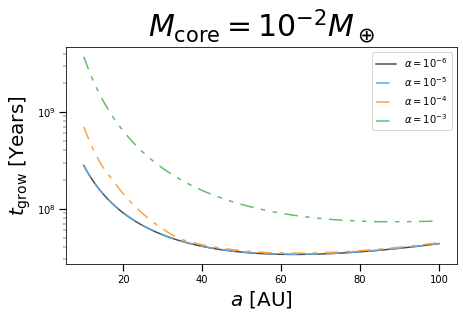

In [5]:
fig = plt.figure(1,figsize=(7,4))

style_arr = [None] * len(alpha_arr)
style_arr[0] = []

for i in range(len(alpha_arr)-1):
    style_add = [3,5] if i else [9,5]
    style_arr[i+1] = style_arr[i] + style_add

line_list = []

for i in range(len(alpha_arr)):
    line_list.append(plt.semilogy(a_arr,t_grow_arr[i],label=r'$\alpha = 10^{%.3g}$' %np.log10(alpha_arr[i])))
#     plt.loglog(r_arr,ke_arr[i],linestyle="dashed",color=line.get_color())

for i in range(len(alpha_arr)):
    line_list[i][0].set_dashes(style_arr[i])

# plt.loglog(r_arr,np.full(len(r_arr),1),linestyle='dashed')

plt.gca().legend(loc='best',fancybox=True)

# plt.title("$a = 1$ AU, $M_{core} = 10^{-1} M_\oplus$", y=1.02)
plt.xlabel(r"$a$ [AU]",fontsize=20)
plt.ylabel(r"$t_{\rm{grow}}$ [Years]",fontsize=20)

plt.title(r"$M_{\rm{core}} = 10^{%.3g} M_\oplus$" %np.log10(m_inj),y=1.02,fontsize=30)


# plt.axis([3e-2,1e3,5e1,5e6])

plt.tick_params(which='major', length=7,width=1.2)
plt.tick_params(which='minor', length=3.5,width=0.45)

## Making Orbital Separation Gap Plot

In [9]:
a_range = (1,1000) # AU
M_range = (0.1,3) # Solar masses
t_range = (1e4,2.5e6) # Years
sig_range = (10,50) # g/cm^2, Sigma(r) = sig_0 * r^-1

m_max_array = np.zeros([1000,2])
for i in range(1000):
    randoms = np.random.rand(4)
    a = a_range[0] + (a_range[1] - a_range[0]) * randoms[0]
    M = M_range[0] + (M_range[1] - M_range[0]) * randoms[1]
    t = t_range[0] + (t_range[1] - t_range[0]) * randoms[2]
    sig_0 = sig_range[0] + (sig_range[1] - sig_range[0]) * randoms[3]
    
    T = 150 * M**(6/7) * a**(-3/7) # Kelvin
    c_s = fn.sound_speed(T)
    v_k = np.sqrt(fn.G * M*fn.m_sun/(a * fn.au)) # Keplerian velocity in units of cm/s
    v_0 = c_s**2/(2 * v_k)
    St = (a * fn.au)/(2 * v_0 * t)
    m_gf = 8e-3 * a**(-9/2) * (sig_0/5)**3 # M_earths
    m_iso = ((10 * np.pi * sig_0 * (a*fn.au)**2)**(3/2)/((3 * M * fn.m_sun)**(1/2)))/fn.m_earth # M_earths
    m_max = np.minimum(m_gf, m_iso)

    min1 = 2/3 * np.sqrt(fn.G * M*fn.m_sun/(a * fn.au))/c_s * St
    min2 = np.sqrt(St)/3
    pre_factor = np.minimum(min1, min2)
    M_th = 22.5/318 * (a/5)**(3/4) # M_earths
    m_fi = pre_factor*M_th # fi for Flow Isolation
    m_final = np.maximum(m_max, m_fi)
    
    m_max_array[i] = np.array([a, m_final])

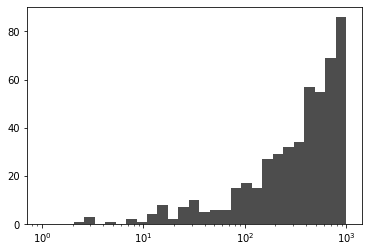

In [16]:
plt.xscale('log')
bins_arr = np.logspace(0,3,30)
plt.hist(m_max_array[:,1], bins=bins_arr);